fase de clasificacion supervisada: preparar cuadernillos con los experimentos, explicar modelos utilizados (reg log, random forest ... cnn), comparar rendimiendo y buscar formas para mejorar

Una vez obtenido un dataset con suficientes noticias de cada categoria objetivo, procedimos a realizar los primeros entrenamientos de distintos modelos de clasificacion supervisada, contemplando tambien una fase de preprocesamiento de la entrada para mejorar en algunos aspectos y simplificar otros...

# Preprocesamiento

## Titulo y cuerpo de la noticia

Como se comento en pasos anteriores, el titulo de una noticia es de gran importancia ya que concentra una gran cantidad de informacion, por lo que es una buena idea incluirlo dentro de los datos con los que se entrenaran nuestros modelos. El dataset contiene una columna 'content' en el que se encuentra el titulo de la noticia mas el cuerpo 

...

In [2]:
import pandas as pd
from pandasql import sqldf

In [3]:
df = pd.read_csv('dataset_paso_3.csv')
pd.set_option('display.max_colwidth', 200)
df[['title', 'content']].head(1)

,title,content
0,"Vacunación en Chile empezaría primer trimestre del 2021 e incluiría a 15,2 millones de personas","Vacunación en Chile empezaría primer trimestre del 2021 e incluiría a 15,2 millones de personas. Este martes, el Presidente Sebastián Piñera anunció que el plan de vacunación para combatir el cor..."


## Truncar contenido


habria que probar si esto mejora los pasos anteriores (lda) xd

In [4]:
lol = df.content.map(len).idxmax()
df.iloc[lol].content # ?????

'Chile: El plebiscito amenazado.  “Los guerreros victoriosos ganan primero y luego van a la guerra, mientras que los guerreros derrotados van a la guerra primero y luego buscan ganar” Sun Tzu 1.-Resumen Ante el próximo plebiscito por una nueva constitución, se analiza y evalúa la actual ofensiva de parte de la derecha para su neutralización. Se busca evitar la opción de Piñera de no realizar el plebiscito, haciendo del apruebo un consenso de gobierno y oposición, generando una situación en que todos estamos por el apruebo, evitando así el triunfo del progresismo y la ciudadanía. Por Alejandro Navarro Brain 2.- Escenarios de la votación para el 25 de octubre 2.1.- Alta participación y alta diferencia de votos 2.2.- Alta participación y baja diferencia de votos 2.3.- Baja participación y alta diferencia de votos 2.4.- Baja participación y baja diferencia de votos. 3.- Estrategias de campaña de la derecha en el plebiscito 3.1.-Pandemia, miedo y abstención: Con la situación de la pandemia,

## Cuanto truncar??

### Por caracteres o por palabras? asegurarse de que la ultima palabra no se corte?

In [5]:
MAX_LEN = 400
df['content'] = df.content.str.slice(0, MAX_LEN)

In [6]:
print('min len: ', df.content.map(len).min())
print('max len: ', df.content.map(len).max())

min len:  184
max len:  400


In [7]:
q="""SELECT category, count(*) FROM df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,3-Política_y_Conflictos,8977
1,1-Mundo,8609
2,9-Crimen_delitos_y_Justicia,8213
3,7-Deporte,6708
4,4-Ciencias_y_Tecnología,4778
5,10-Salud,2690
6,2-Economía,2636
7,5-Catástrofes_y_Accidentes,1245
8,8-Ecología_y_Planeta,863
9,6-Cultura_y_Artes,795


# balancear el dataset alan tigua?

In [8]:
new_df = df.groupby('category').sample(n=795, random_state=2)
new_df.reset_index(drop=True, inplace=True)
new_df.head(5)

,id,title,content,category
0,5708146,ONU advierte que la vacuna no basta para enfrentar la devastación del Covid-19,"ONU advierte que la vacuna no basta para enfrentar la devastación del Covid-19. La vacuna contra el Covid-19 no pone fin a la devastación causada por la pandemia en el mundo, alertó el jueves el j...",1-Mundo
1,6664788,11 millones de niñas en el mundo corren el riesgo de no volver a clases por el coronavirus,11 millones de niñas en el mundo corren el riesgo de no volver a clases por el coronavirus. Once millones de niñas en todo el mundo corren el riesgo de no volver a la escuela cuando terminen las r...,1-Mundo
2,14776151,Canciller de Brasil presenta su renuncia tras presiones de legisladores bolsonaristas,"Canciller de Brasil presenta su renuncia tras presiones de legisladores bolsonaristas. El ministro de Relaciones Exteriores de Brasil, Ernesto Araújo , presentó este lunes su renuncia, tras fuert...",1-Mundo
3,5742144,Viajes en un mundo posterior a la pandemia del coronavirus,Viajes en un mundo posterior a la pandemia del coronavirus. Se espera un enfriamiento del romance con las capitales europeas y que exista un nuevo cariño por las ciudades menos pobladas con grande...,1-Mundo
4,14798264,Oposición gana las elecciones presidenciales en las islas Seychelles por primera vez en 40 años,"Oposición gana las elecciones presidenciales en las islas Seychelles por primera vez en 40 años. El opositor Wavel Ramkalawan se convirtió este domingo, con un 54,9% de los votos, en el quinto pr...",1-Mundo


In [9]:
q="""SELECT category, count(*) FROM new_df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,9-Crimen_delitos_y_Justicia,795
1,8-Ecología_y_Planeta,795
2,7-Deporte,795
3,6-Cultura_y_Artes,795
4,5-Catástrofes_y_Accidentes,795
5,4-Ciencias_y_Tecnología,795
6,3-Política_y_Conflictos,795
7,2-Economía,795
8,10-Salud,795
9,1-Mundo,795


# Lo que hice en la tarea de IA 


## Bag of words + tf-idf

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

## NLTK

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize.casual import casual_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation
import re
from tqdm.auto import tqdm

In [11]:
#nltk.download('stopwords')
#nltk.download('punkt')

In [12]:
#stopwords
spanish_stopwords = stopwords.words('spanish')

#stemmer
stemmer = SnowballStemmer('spanish')

#puntuacion
non_words = list(punctuation)
#incluir puntuacion del español
non_words.extend(['¿', '¡'])
#numeros
non_words.extend(map(str,range(10)))

# Incluir n-grams?

In [13]:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def text_cleaner(text, stem=False):
    # puntuacion
    text = ''.join([c for c in text if c not in non_words])
    # caracteres repetidos
    text = re.sub(r'(.)\1+', r'\1\1', text)
    # tokenize
    tokens = casual_tokenize(text, preserve_case=False)
    # quitar stopwords
    filtered_sentence = [w for w in tokens if not w in spanish_stopwords]
    # stemming
    if stem:
        filtered_sentence = stem_tokens(filtered_sentence, stemmer)
    
    return " ".join(filtered_sentence)

In [16]:
train_size = 0.70

In [17]:
train_idxs = new_df.groupby('category').sample(frac=train_size, random_state=2).index
train_df = new_df.iloc[train_idxs]
q="""SELECT category, count(*) FROM train_df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,9-Crimen_delitos_y_Justicia,556
1,8-Ecología_y_Planeta,556
2,7-Deporte,556
3,6-Cultura_y_Artes,556
4,5-Catástrofes_y_Accidentes,556
5,4-Ciencias_y_Tecnología,556
6,3-Política_y_Conflictos,556
7,2-Economía,556
8,10-Salud,556
9,1-Mundo,556


In [18]:
test_idxs = pd.concat([new_df, train_df]).drop_duplicates(keep=False).index
test_df = new_df.iloc[test_idxs]
q="""SELECT category, count(*) FROM test_df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,9-Crimen_delitos_y_Justicia,239
1,8-Ecología_y_Planeta,239
2,7-Deporte,239
3,6-Cultura_y_Artes,239
4,5-Catástrofes_y_Accidentes,239
5,4-Ciencias_y_Tecnología,239
6,3-Política_y_Conflictos,239
7,2-Economía,239
8,10-Salud,239
9,1-Mundo,239


In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib notebook
from functools import partial
import numpy as np

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [21]:
lb = LabelEncoder()
ylabels = new_df['category']
# unique_labels = sorted(ylabels.unique(), key=lambda x : len(x.split('-')[0]))
lb.fit(ylabels.unique())
true_labels = [lb.inverse_transform([i])[0] for i in range(ylabels.nunique())]
ylabels_train_target = lb.fit_transform(ylabels[train_idxs])
ylabels_test_target = lb.fit_transform(ylabels[test_idxs])

# tendriamos que hacer zfill para que queden ordenadas (01-mundo, 02- economia)
# o quitar el numero y ya xd
for label in true_labels:
    print(f" {label:<12} :  {lb.transform([label])[0]}")

 1-Mundo      :  0
 10-Salud     :  1
 2-Economía   :  2
 3-Política_y_Conflictos :  3
 4-Ciencias_y_Tecnología :  4
 5-Catástrofes_y_Accidentes :  5
 6-Cultura_y_Artes :  6
 7-Deporte    :  7
 8-Ecología_y_Planeta :  8
 9-Crimen_delitos_y_Justicia :  9


In [22]:
# Word tokenization
from spacy.lang.es import Spanish

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = Spanish()

text = new_df.sample(n=1)['content'].values[0][:100]
#  "nlp" Object is used to create documents with linguistic annotations.
my_doc = nlp(text)

# Create list of word tokens
token_list = []
for token in my_doc:
    token_list.append(token.text)
print(token_list)

['Bolsonaro', 'extiende', 'la', 'polémica', 'militarización', 'de', 'la', 'Amazonía', 'brasileña', '.', 'Jair', 'Bolsonaro', 'tiene', 'a', 'los', 'b']


In [23]:
#Stop words
#importing stop words from English language.
from spacy.lang.es.stop_words import STOP_WORDS

#Implementation of stop words:
filtered_sent=[]

#  "nlp" Object is used to create documents with linguistic annotations.
doc = nlp(text)

for word in doc:
    if word.is_stop==False:
        filtered_sent.append(word)
print("Filtered Sentence:",filtered_sent)

Filtered Sentence: [Bolsonaro, extiende, polémica, militarización, Amazonía, brasileña, ., Jair, Bolsonaro, a, b]


In [24]:
import string
import spacy

nlp = spacy.load('es_core_news_md', disable=['parser','ner','textcat','...'] )
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("es_core_news_md")
stop_words = STOP_WORDS

In [25]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

# Creating our tokenizer function
def spacy_tokenizer(sentence, stem=False):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens]
    
    # Removing stop words, ver lo de puntuuacion con  token.tag_
    mytokens = [ word for word in mytokens 
                          if word not in stop_words 
                          and word not in punctuations ]
    if stem:
        mytokens = [ stemmer.stem(word) for word in mytokens ]
    # return preprocessed list of tokens
    return " ".join(mytokens)

In [34]:
contento = new_df.content[5]
print(len(contento))
contento

400


'En previa de reunión de mediadores: Bombardean emblemática catedral en Nagorno Karabaj. Fuerzas armenias y azerbaiyanas continuaban sus combates este jueves en Nagorno Karabaj, donde una emblemática catedral armenia fue bombardeada en dos ocasiones, un mal presagio de cara a la primera reunión en Ginebra de los mediadores internacionales en el conflicto. Los bombardeos azerbaiyanos continuaron dur'

In [33]:
%%timeit
text_cleaner(contento)

776 µs ± 68.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
text_cleaner(contento)

'previa reunión mediadores bombardean emblemática catedral nagorno karabaj fuerzas armenias azerbaiyanas continuaban combates jueves nagorno karabaj emblemática catedral armenia bombardeada dos ocasiones mal presagio cara primera reunión ginebra mediadores internacionales conflicto bombardeos azerbaiyanos continuaron dur'

In [37]:
%%timeit
spacy_tokenizer(contento)

14.2 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
text_cleaner(contento, stem=True)

'previ reunion mediador bombard emblemat catedral nagorn karabaj fuerz armeni azerbaiyan continu combat juev nagorn karabaj emblemat catedral armeni bombard dos ocasion mal presagi car primer reunion ginebr mediador internacional conflict bombarde azerbaiyan continu dur'

In [38]:
spacy_tokenizer(contento)

'previa reunión mediador bombardean emblemático catedral nagorno karabaj fuerzas armenia y azerbaiyana continuar combate jueves nagorno karabaj emblemático catedral armenio bombardear ocasión presagio cara a reunión ginebra mediador internacional conflicto bombardeo azerbaiyano continuar dur'

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, classification_report
from functools import partial
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [40]:
%%time
vectorizer = TfidfVectorizer(preprocessor=partial(spacy_tokenizer, stem=False))
XD = vectorizer.fit_transform(new_df['content'])
feature_names = vectorizer.get_feature_names()

CPU times: user 2min 15s, sys: 131 ms, total: 2min 15s
Wall time: 2min 15s


In [41]:
X_train = XD[train_idxs]
X_test = XD[test_idxs]

In [42]:
lgr = LogisticRegression(random_state=42, multi_class='ovr', class_weight=None)
lgr.fit(X_train, ylabels_train_target)

LogisticRegression(multi_class='ovr', random_state=42)

In [47]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=100,
              random_state=42, criterion='gini', class_weight=None,
              max_features='sqrt', verbose=0)
rfc.fit(X_train, ylabels_train_target)

RandomForestClassifier(max_depth=100, max_features='sqrt', random_state=42)

In [ ]:
from my_funcs import results

Resultados clasificación
RandomForestClassifier


                             precision    recall  f1-score   support

                    1-Mundo       0.72      0.63      0.67       239
                   10-Salud       0.59      0.73      0.65       239
                 2-Economía       0.73      0.62      0.67       239
    3-Política_y_Conflictos       0.65      0.72      0.69       239
    4-Ciencias_y_Tecnología       0.70      0.69      0.70       239
 5-Catástrofes_y_Accidentes       0.69      0.82      0.75       239
          6-Cultura_y_Artes       0.82      0.67      0.74       239
                  7-Deporte       0.88      0.95      0.91       239
       8-Ecología_y_Planeta       0.83      0.75      0.79       239
9-Crimen_delitos_y_Justicia       0.76      0.72      0.74       239

                   accuracy                           0.73      2390
                  macro avg       0.74      0.73      0.73      2390
               weighted avg       0.74      0.73   

<IPython.core.display.Javascript object>


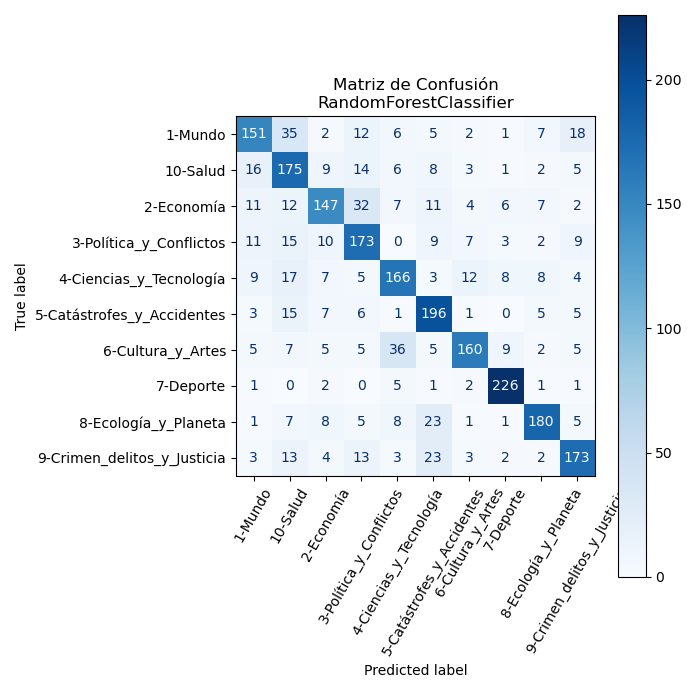

In [48]:
results(ylabels_test_target, rfc, X_test)

Resultados clasificación
LogisticRegression


                             precision    recall  f1-score   support

                    1-Mundo       0.75      0.77      0.76       239
                   10-Salud       0.74      0.78      0.76       239
                 2-Economía       0.79      0.77      0.78       239
    3-Política_y_Conflictos       0.73      0.75      0.74       239
    4-Ciencias_y_Tecnología       0.79      0.74      0.76       239
 5-Catástrofes_y_Accidentes       0.79      0.85      0.82       239
          6-Cultura_y_Artes       0.81      0.82      0.81       239
                  7-Deporte       0.96      0.95      0.96       239
       8-Ecología_y_Planeta       0.87      0.78      0.83       239
9-Crimen_delitos_y_Justicia       0.79      0.80      0.80       239

                   accuracy                           0.80      2390
                  macro avg       0.80      0.80      0.80      2390
               weighted avg       0.80      0.80      0

<IPython.core.display.Javascript object>


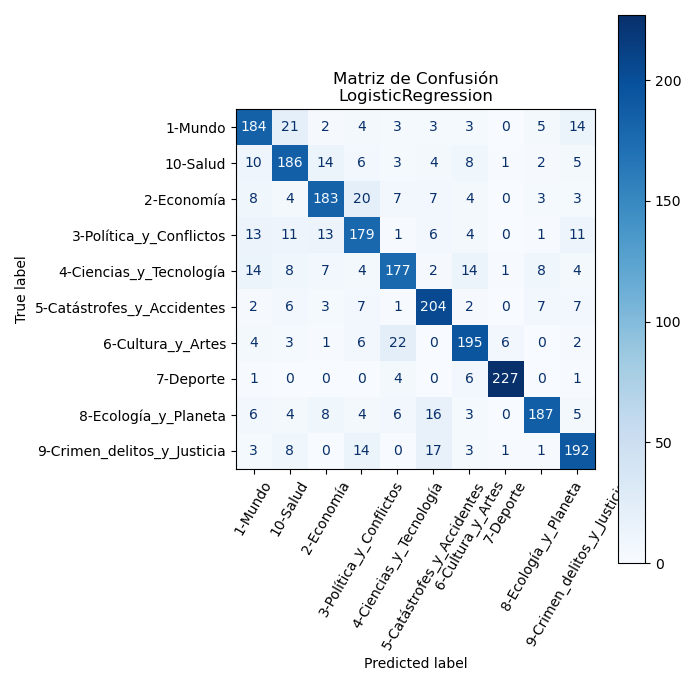

In [49]:
results(ylabels_test_target, lgr, X_test)